The purpose of this notebook is to develop architecture and utilities for fit neural network on B → J reconstruction problem.

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [3]:
from IPython.display import display, clear_output

In [4]:
import sys
sys.path.append('../../..')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

In [6]:
from magrec.misc.load import load_matlab_data

In [7]:
# experimental data where three components of the magnetic field are measured above an Nb wire
# data is from DOI: 10.1103/PhysRevApplied.14.024076
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt")

B = torch.tensor(np.array([Bx, By, Bz]), dtype=torch.float32)

dx = 0.408  # in μm
dy = 0.408

height = 0.015          # μm
layer_thickness = 0.030 # μm

# this is an axis along which the magnetic field is *usually* measured
# in this case we will project the measured components to simulate such case
theta = 54.7            # degrees
phi = 45.0              # degrees

In [11]:
B.shape

torch.Size([3, 201, 201])

# Neural net architecture

In [8]:
from magrec.prop.Pipeline import (
    Pipe,
    HannFilter, 
    GaussianFilter,
    Union, 
    PlotResults, 
    FourierZeroDivergenceConstraint2d, 
    CurrentLayerToField, 
    Projection, 
    Sandwich, 
    Padder, 
    Function,
)

from magrec.scripts.prototype_pipeline import Prototype

from magrec.nn.arch import UNet, BnCNN

In [9]:
from magrec.scripts.prototype_pipeline import Prototype

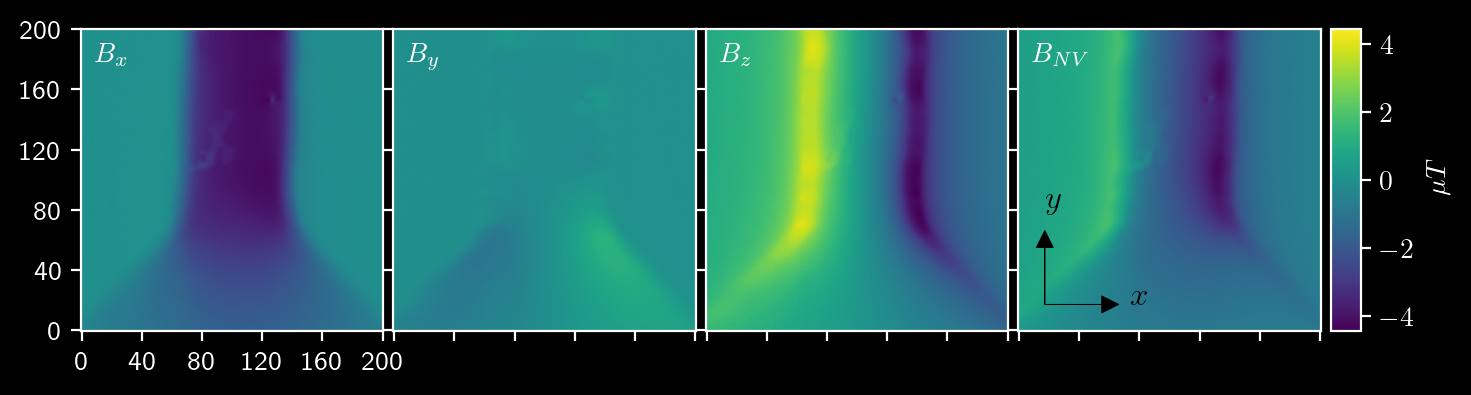

In [40]:
pipe = Pipe([  
    # NV stands for nitrogen-vacancy (its a quantum defect in diamond crystal used for measuring magnetic field and quantum computing)
    ('B+B_NV', Union([
        ('B', 'passthrough'),
        ('B_NV', Projection(theta=theta, phi=phi)),
    ], dim=-3)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[None, [-1], :, :])),
    ('padded_B_NV', Padder(up_to=(16*20, 16*20))),
])

pipe.fit(B).transform(B);

model = Pipe([
    # ('JxJy', Union([('Jx', FourierZeroDivergenceConstraint2d()), ('Jy', 'passthrough')], dim=-3)),
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=BnCNN, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

  epoch    train_loss       dur
-------  ------------  --------
    209      2.69e-03  1.97e-01
    220      2.44e-03  1.84e-01
    240      2.43e-03  3.09e-01
    260      2.17e-03  2.62e-01
    280      2.04e-03  1.68e-01
    300      1.89e-03  1.52e-01
    320      1.88e-03  1.79e-01
    340      1.74e-03  1.47e-01
    360      1.70e-03  1.47e-01
    380      1.55e-03  2.07e-01
    400      1.47e-03  1.53e-01


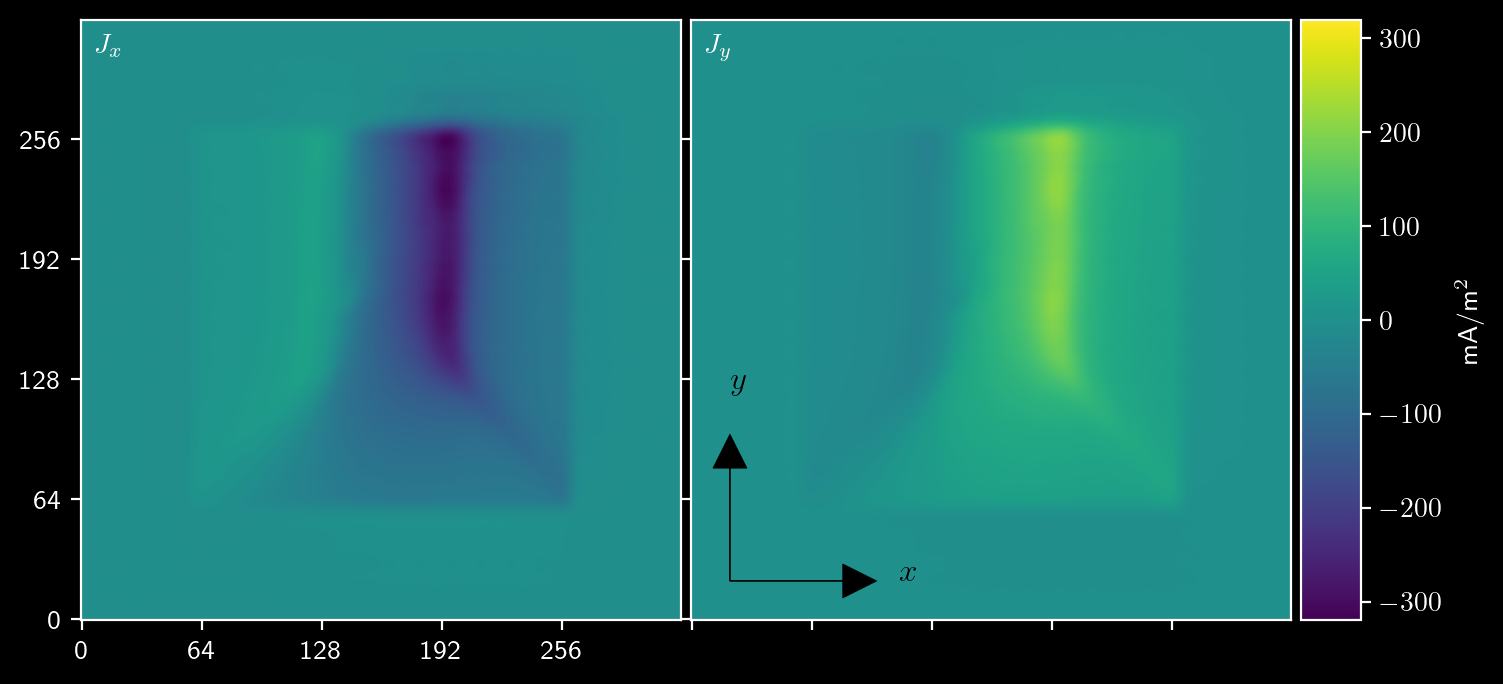

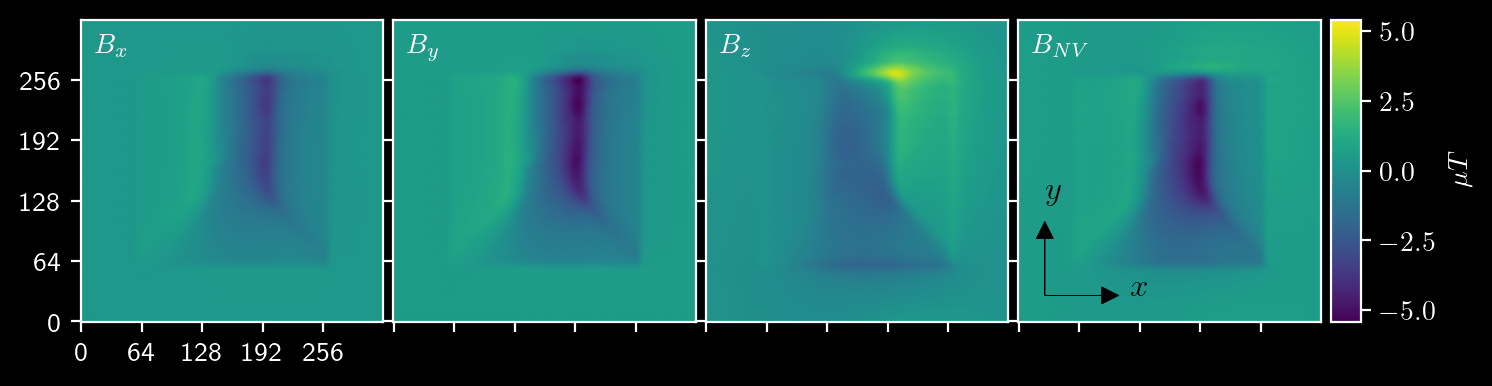

tensor([[[[0.6050, 0.5989, 0.5940,  ..., 0.6247, 0.6218, 0.6159],
          [0.5926, 0.5838, 0.5765,  ..., 0.6158, 0.6142, 0.6079],
          [0.5802, 0.5685, 0.5595,  ..., 0.6081, 0.6081, 0.6012],
          ...,
          [0.6113, 0.6028, 0.5962,  ..., 0.6226, 0.6235, 0.6216],
          [0.6119, 0.6048, 0.5997,  ..., 0.6226, 0.6224, 0.6202],
          [0.6105, 0.6045, 0.6001,  ..., 0.6230, 0.6215, 0.6183]]]],
       grad_fn=<IndexBackward0>)

In [43]:
recon.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=0.1)